In [1]:
import numpy as np
from scipy import interpolate
import os
import sys
import lumapi

sys.path.append('D:\\program\\adjoint_method\\Lumopt\\src')
from Utilities.wavelength import Wavelength
from Utilities.base_script import BaseScript
from Geometries.topology import Density2D
from Geometries.polygon import FunctionDefinedPolygon
from Figures_of_merit.modematch import PolarMatch
from Optimizers.generic_optimizers import ScipyOptimizers
from optimization import Optimization
from Utilities.simulation import Simulation
from Lumerical_methods.lumerical_scripts import get_eps_from_sim


%load_ext autoreload
%autoreload 2

Extract the geometry and convert it into density representation

In [2]:
## Define base script ##
base_script = os.path.join(os.getcwd(), 'Hexagonal2D_new.lsf')
base_script = BaseScript(base_script)

workingDir = os.getcwd()
sim = Simulation(workingDir, use_var_fdtd=False, hide_fdtd_cad=False)
base_script(sim.fdtd)
Optimization.add_index_monitor(sim, 'opt_fields')
sim.run('test', 0)  # Run the simulation so that we can use getnamed

epsilon, x, y, __, __ = get_eps_from_sim(sim.fdtd)
initial_eps = np.real(epsilon[:, :, 0, 0, 0])
x = x.reshape(-1) # Be aware that the original x shape is a 2D array
y = y.reshape(-1)
z0 = sim.fdtd.getnamed('rect_pc', 'z')
z_span = sim.fdtd.getnamed('rect_pc', 'z span')
z = np.array([z0-z_span/2, z0+z_span/2])

del sim, workingDir

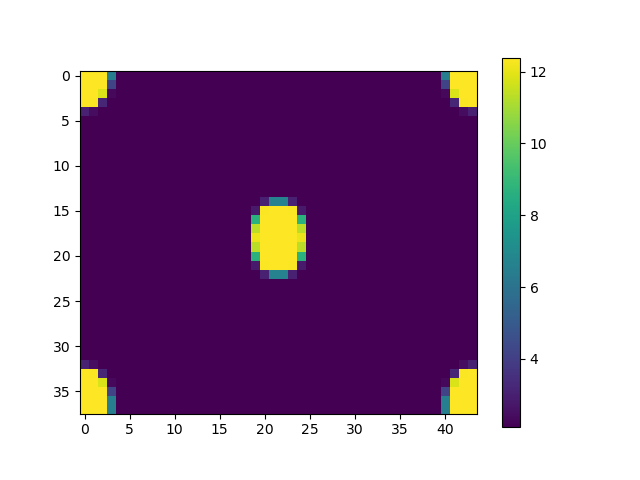

In [3]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.imshow(initial_eps)
plt.colorbar()

In [5]:
wavelength = Wavelength(1354e-9, 1354e-9, 1)
geometry = Density2D(initial_eps, x, y, z, 1, 20)
fom = PolarMatch(monitor_name='fom', theta=0, phi=0, pol_state=np.sqrt(2)/2*np.array([1,-1j]), direction='Backward')
optimizer = ScipyOptimizers(max_iter = 30, method = 'L-BFGS-B', scaling_factor = 1, pgtol = 1e-5)

opt = Optimization(base_script = base_script, wavelength = wavelength, fom = fom, geometry = geometry, optimizer = optimizer,src_names=['source_x', 'source_y'], hide_fdtd_cad = False, dir_grad = False)
initial_params = geometry.params

The wavelength setting of the source will be superseded by the global settings
The wavelength setting of the source will be superseded by the global settings


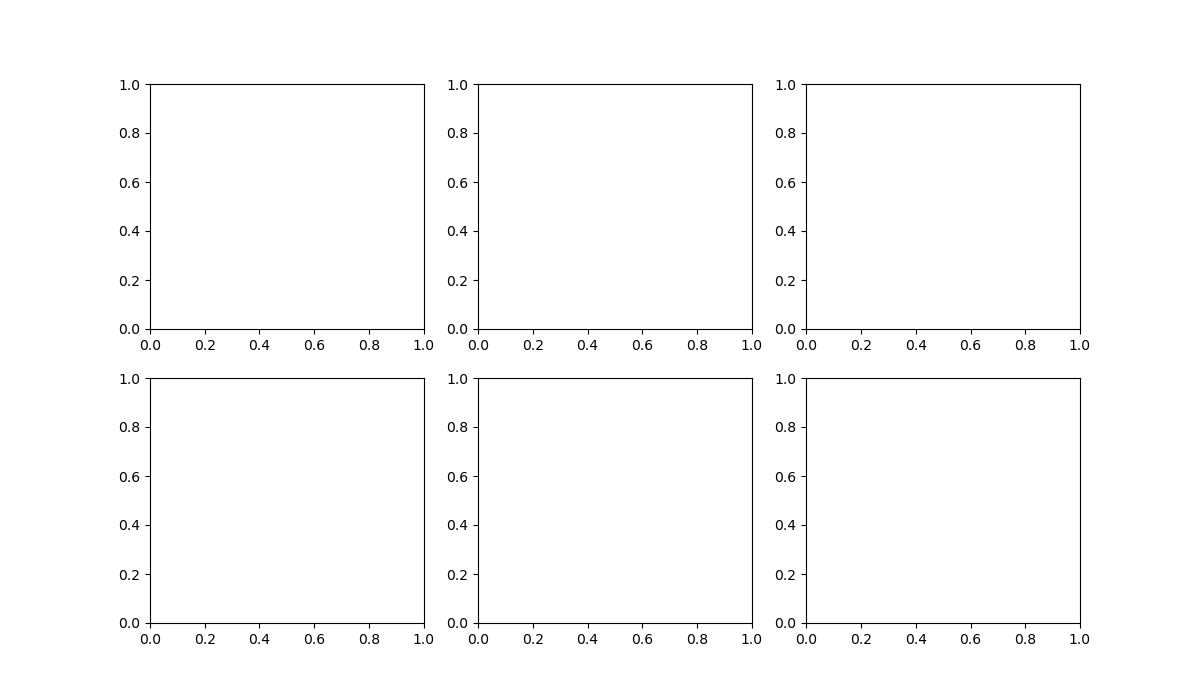

Running forward simulation
FOM = [0.05546561]
Running adjoint simulation
Calculating gradients


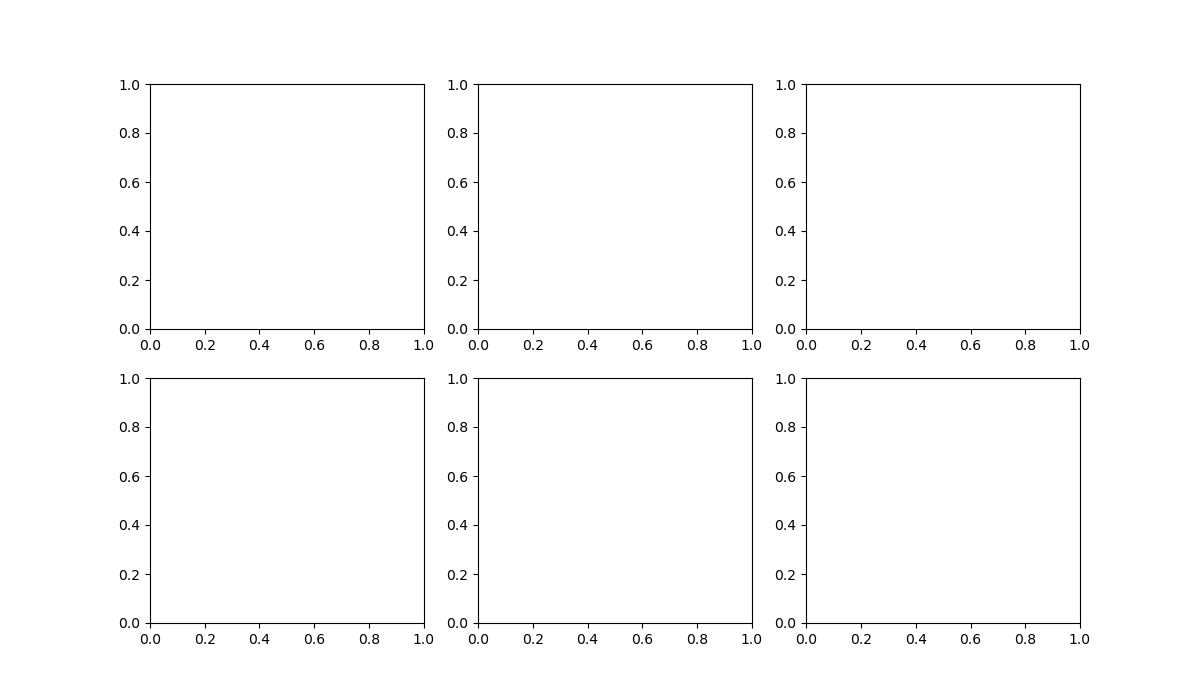

In [6]:
opt.initialize()
opt.init_plotter()
# grad_adj = []
# for i in range(20, 26):
#     script = 'setnamed("opt_fields", "z", z_data({}));'.format(i)
#     opt.sim.fdtd.eval(script)
#     fom_To = opt.callable_fom(initial_params)
#     grad_adj.append(opt.callable_jac(initial_params))
# np.save('D:\\program\\adjoint_method\\Lumopt\\Example\\Polarization_control\\gradient_data\\tri_grad_adj_p_p.npy', grad_adj)
fom_To, __ = opt.callable_fom(initial_params)
grad_adj = opt.callable_jac(initial_params)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.imshow(np.reshape(grad_T, geometry.size))
plt.colorbar()

Text(0.5, 1.0, 'tri_dir_grad_p_s_10_19')

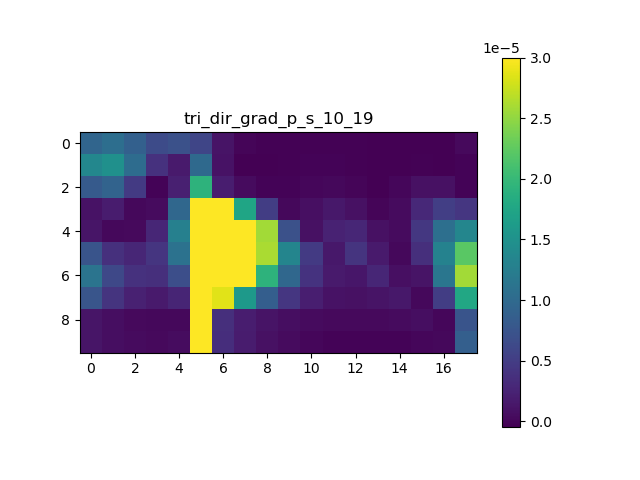

In [42]:
import matplotlib.pyplot as plt
%matplotlib widget
path = 'D:\\program\\adjoint_method\\Lumopt\\Example\\Polarization_control\\gradient_data\\tri_dir_grad_p_s_11_21.npy'
# grad = np.load(path)
# grad = np.sum(np.array(grad), axis=0)
# grad = np.reshape(grad, geometry.size)
grad_1 = np.load(path)
grad_1 = np.reshape(grad_1, (11, 21))
# grad_f = grad[0:11, 0:11] 
plt.imshow(grad_1[1:11,1:19], vmax=0.00003)
plt.colorbar()
plt.title('tri_dir_grad_p_s_10_19')

In [7]:
dx = 1e-5
grad_1_d = []
sp_components = []
num = []
for i in range(19):
    for j in range(44):
        num.append(44*i + j)

for index in num:
    d_params = initial_params.copy()
    d_params[index] = d_params[index] + dx # perturb the first parameter
    fom_T1, sp_component = opt.callable_fom(d_params)
    sp_components.append(sp_component)
    grad_1_d.append((fom_T1 - fom_To) / dx) # 1 stands for the first parameter and d stands for direct differentiation
grad_1_d = np.array(grad_1_d)
sp_components = np.array(sp_components)

Running forward simulation
FOM = [0.05635986]
Running forward simulation
FOM = [0.05594195]
Running forward simulation
FOM = [0.05514984]
Running forward simulation
FOM = [0.05550855]
Running forward simulation
FOM = [0.05588074]
Running forward simulation
FOM = [0.05546424]
Running forward simulation
FOM = [0.05546481]
Running forward simulation
FOM = [0.05546512]
Running forward simulation
FOM = [0.05546542]
Running forward simulation
FOM = [0.0554657]
Running forward simulation
FOM = [0.0554659]
Running forward simulation
FOM = [0.05546599]
Running forward simulation
FOM = [0.05546594]
Running forward simulation
FOM = [0.05546578]
Running forward simulation
FOM = [0.05546556]
Running forward simulation
FOM = [0.05546535]
Running forward simulation
FOM = [0.05546521]
Running forward simulation


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib widget
### Draw the gradient_T and gradient_1_d fields ###
fig = plt.figure(num = 1,figsize = (4, 4))

ax1 = fig.add_subplot(221)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
ax1.plot(np.linspace(1, 10, 10), grad_1[8, 1:], '.-', label = 'm_adjoint_modified')
ax1.legend(fontsize = 6)

ax2 = fig.add_subplot(222)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
ax2.plot(np.linspace(1, 11, 11), grad[8, 0:11], '*--', label = 'my_adjoint_modified')
ax2.legend(fontsize = 6)

ax1.set_xlabel('parameter index')
ax1.set_ylabel('gradient')
ax1.set_title('test_grad dx = 1e-9')

The following is used to check the correctness of calculating fom and gradients

In [ ]:
import sys
sys.path.append('D:\\program\\adjoint_method\\Lumopt')
sys.path.append('D:\\program\\adjoint_method\\Lumopt\\src')
import numpy as np
import lumapi
from src.Polarization.extract_polar import extract_polar

%load_ext autoreload
%autoreload 2

In [ ]:
path = 'D:\\polarization_control\\Square2D_new'
fdtd = lumapi.FDTD(filename = path)
wavelength = np.linspace(5.02e-7, 6.02e-7, 11)
fdtd.run()
sp_component = extract_polar(fdtd, 'monitor_xy_1', wavelength, 0, 0, False)
fdtd.close()

In [7]:
np.save('D:\\program\\adjoint_method\\Lumopt\\Example\\Polarization_control\\gradient_data\\tri_dir_grad_p_p_11_21.npy', grad_1_d)

In [1]:
a = np.array([1/np.sqrt(2),1/np.sqrt(2)*1j])
np.linalg.norm(a)

NameError: name 'np' is not defined

In [6]:
x[1:]-x[:-1]

array([2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08, 2.7027027e-08, 2.7027027e-08, 2.7027027e-08,
       2.7027027e-08])